# Facial Expression Recognition


## Data Preprocessing

In [53]:
#import libraries
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

In [54]:
#input the dataset 
data_dir = '/kaggle/input/human-face-emotions/data'

#display the content of the dataset
content = os.listdir(data_dir)

print(f"Expressions(classes) in the dataset:", content)

total = 0
#display number of images in each class
for folder in content:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        total = total + num_images
        print(f"Number of images in '{folder}' mood: {num_images}")
        
print(f"total number of images in the dataset:", total)

Expressions(classes) in the dataset: ['Angry', 'Sad', 'Happy']
Number of images in 'Angry' mood: 86
Number of images in 'Sad' mood: 79
Number of images in 'Happy' mood: 100
total number of images in the dataset: 265


In [ ]:
#display images in the dataset
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i, folder in enumerate(content):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)[:3] #display first 3 images of each class
        for j, image_file in enumerate(images):
            image_path = os.path.join(folder_path, image_file)
            image = Image.open(image_path)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            axes[i, j].set_title(folder)

plt.tight_layout()
plt.show()

In [56]:
import os
import pandas as pd
from pathlib import Path

filenames = []
labels = []

def convert_to_df(dataset, image_formats=('jpg', 'jpeg', 'png', 'gif')):
    img_dir = Path(dataset)
    global filenames,labels
    filenames = [file for file in img_dir.glob('**/*') if file.suffix.lower().lstrip('.') in image_formats]
    labels = [os.path.split(file.parts[-2])[1] for file in filenames]

    img_df = pd.DataFrame({'filepath': filenames, 'label': labels})
    return img_df

img_df = convert_to_df(data_dir)

#display first few of the converted dataset
img_df.head()


,filepath,label
0,/kaggle/input/human-face-emotions/data/Angry/1...,Angry
1,/kaggle/input/human-face-emotions/data/Angry/1...,Angry
2,/kaggle/input/human-face-emotions/data/Angry/f...,Angry
3,/kaggle/input/human-face-emotions/data/Angry/g...,Angry
4,/kaggle/input/human-face-emotions/data/Angry/s...,Angry


In [57]:
print("Number of entries in img_df:", img_df.shape[0])


Number of entries in img_df: 265


In [58]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(img_df, test_size=0.2, random_state=42)

print("Number of samples in training set:", len(train_df))
print("Number of samples in validation set:", len(val_df))


Number of samples in training set: 212
Number of samples in validation set: 53


In [59]:
print(train_df[:5])

                                              filepath  label
172  /kaggle/input/human-face-emotions/data/Happy/g...  Happy
232  /kaggle/input/human-face-emotions/data/Happy/7...  Happy
18   /kaggle/input/human-face-emotions/data/Angry/g...  Angry
90   /kaggle/input/human-face-emotions/data/Sad/por...    Sad
182  /kaggle/input/human-face-emotions/data/Happy/n...  Happy


In [60]:
print(val_df[:5]) 

                                              filepath  label
179  /kaggle/input/human-face-emotions/data/Happy/i...  Happy
115  /kaggle/input/human-face-emotions/data/Sad/cry...    Sad
96   /kaggle/input/human-face-emotions/data/Sad/afr...    Sad
24   /kaggle/input/human-face-emotions/data/Angry/A...  Angry
9    /kaggle/input/human-face-emotions/data/Angry/4...  Angry


In [61]:
def augmentation_images(df, target_size=(224, 224)):
    images = []
    labels = []

    for index, row in df.iterrows():
        img = load_img(row['filepath'], target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(row['label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Perform data augmentation
    datagen = ImageDataGenerator(
         rotation_range=20,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#          shear_range=0.5,
         zoom_range=0.2,
         horizontal_flip=True,
#          brightness_range=[0.7, 1.3],
#          fill_mode='nearest'
    )
    
    datagen.fit(images)
    original_images = []
    original_labels = []
    augmented_images = []
    augmented_labels = []

    # Generate augmented images 
    for X_batch, y_batch in datagen.flow(images, labels, batch_size=len(images), shuffle=False):
        for i in range(len(X_batch)):
            original_img = array_to_img(images[i])
            augmented_img = array_to_img(X_batch[i])
            if i <= 2:
                # Create a figure with two subplots: one for the original image and one for the augmented image
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))

                # Display the original image
                axes[0].imshow(original_img)
                axes[0].set_title("Original Image (Label: " + str(labels[i]) + ")")
                axes[0].axis('off')

                # Display the augmented image
                axes[1].imshow(augmented_img)
                axes[1].set_title("Augmented Image (Label: " + str(y_batch[i]) + ")")
                axes[1].axis('off')

                plt.show()
            
            original_images.append(images[i])
            original_labels.append(labels[i])
            augmented_images.append(X_batch[i])
            augmented_labels.append(y_batch[i])
        break  
    
    all_images = np.concatenate([original_images, augmented_images], axis=0)
    all_labels = np.concatenate([original_labels, augmented_labels], axis=0)

    #number of new images created
    num_original_images = len(images)
    num_augmented_images = len(augmented_images)
    total_images = num_original_images + num_augmented_images
    
    print("Number of original images:", num_original_images)
    print("Number of augmented images:", num_augmented_images)
    print("Total number of images after augmentation:", total_images)
    
    return all_images, all_labels


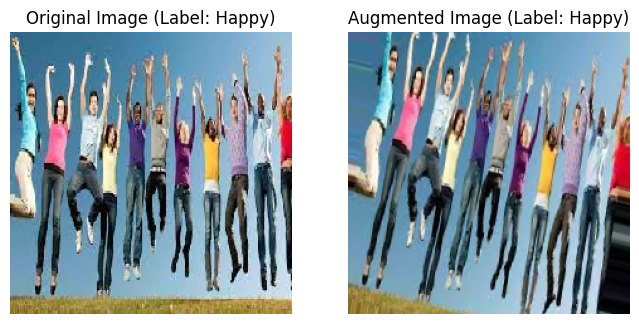

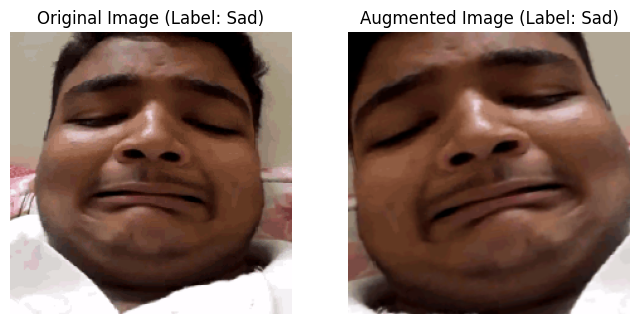

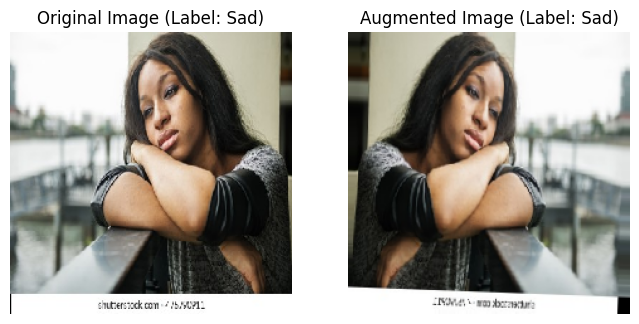

Number of original images: 53
Number of augmented images: 53
Total number of images after augmentation: 106


In [62]:
val_images, val_labels = augmentation_images(val_df)

In [63]:
print(len(val_images))

106


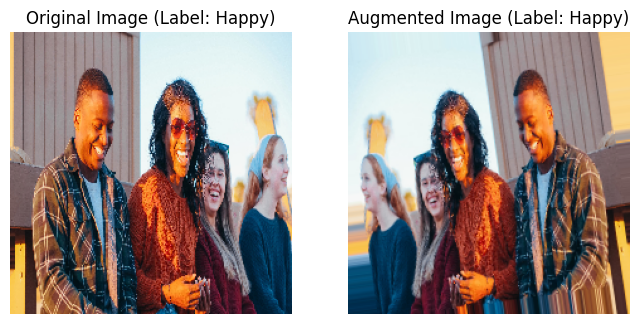

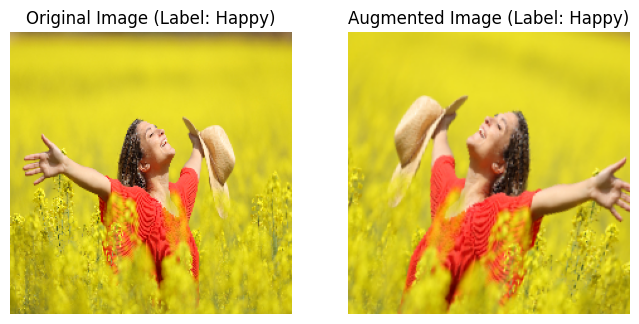

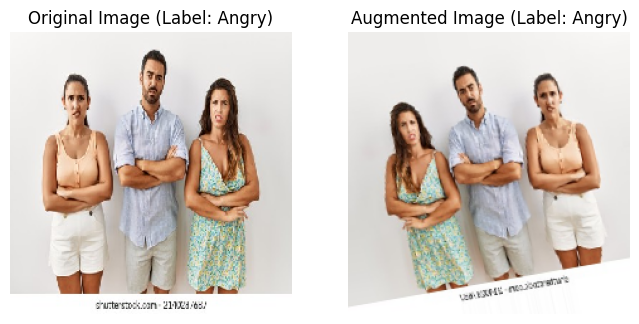

Number of original images: 212
Number of augmented images: 212
Total number of images after augmentation: 424


In [64]:
train_images, train_labels = augmentation_images(train_df)

In [65]:
print("Data type of train_images:", train_images.dtype)
print("Data type of train_labels:", train_labels.dtype)


Data type of train_images: float32
Data type of train_labels: <U5


In [66]:
print("Data type of val_images:", val_images.dtype)
print("Data type of val_labels:", val_labels.dtype)


Data type of val_images: float32
Data type of val_labels: <U5


In [67]:
# Define a mapping from label strings to integers
label_mapping = {'Angry': 0, 'Sad': 1, 'Happy': 2}

# Convert label strings to integers using the mapping
train_labels = np.array([label_mapping[label] for label in train_labels])
val_labels = np.array([label_mapping[label] for label in val_labels])


In [68]:
print("Data type of train_images:", train_images.dtype)
print("Data type of train_labels:", train_labels.dtype)



Data type of train_images: float32
Data type of train_labels: int64


## Model Architecture

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(10, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2),padding='valid'),
        Conv2D(25, (3, 3), activation='relu'),
        MaxPooling2D((2, 2),padding='valid'),
        Conv2D(30, (3, 3), activation='relu'),
        MaxPooling2D((2, 2),padding='valid'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Assuming images are resized to 224x224 with 3 channels (RGB)
num_classes = 3  # Change this to the number of classes in your dataset

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 109, 109, 25)   │         2,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 54, 54, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 52, 52, 30)     │         6,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 26, 26, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 20280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     2,595,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,605,690 (9.94 MB)

 Trainable params: 2,605,690 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [110]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_images,
                    train_labels,
                    batch_size=32,  # specify your batch size here
                    epochs=20,
                    validation_data=(val_images, val_labels))


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.3185 - loss: 627.9282 - val_accuracy: 0.3019 - val_loss: 43.0925
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3508 - loss: 14.6956 - val_accuracy: 0.3113 - val_loss: 1.0950
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3773 - loss: 1.0976 - val_accuracy: 0.3113 - val_loss: 1.0940
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4183 - loss: 1.1274 - val_accuracy: 0.3113 - val_loss: 1.0935
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3765 - loss: 1.0979 - val_accuracy: 0.3113 - val_loss: 1.0938
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3878 - loss: 1.0974 - val_accuracy: 0.3113 - val_loss: 1.0941
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3952 - loss: 1.0971 - val_accuracy: 0.3113 - val_loss: 1.0943
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4028 - loss: 1.0963 - val_accuracy: 0.311

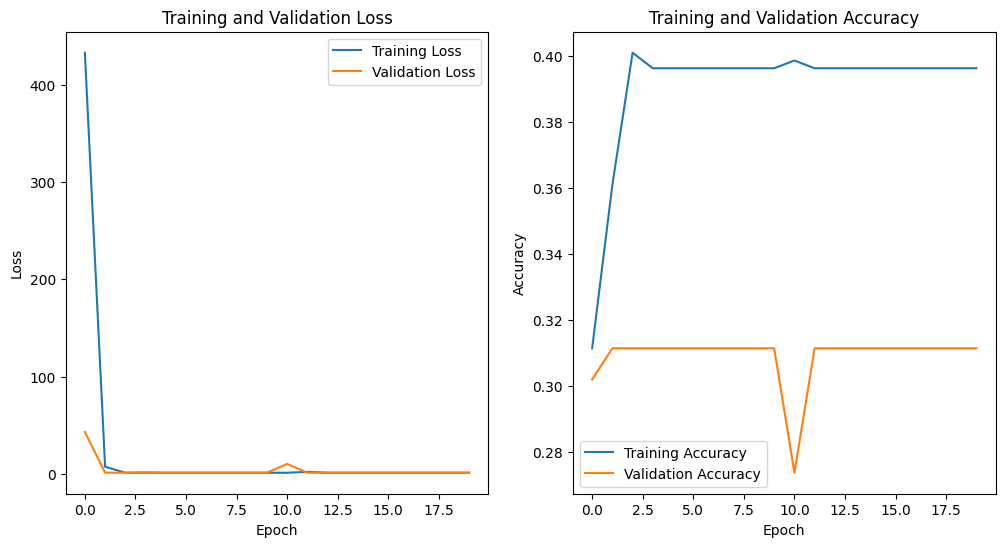

In [111]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and index 1
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and index 2
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [119]:
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.15,
    height_shift_range=0.15,
    vertical_flip=True,
    horizontal_flip=True
)

# Define data augmentation for validation set
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_df['filepath'] = train_df['filepath'].astype(str)
val_df['filepath'] = val_df['filepath'].astype(str)

# Create ImageDataGenerator for training set
train_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=True,
    target_size=(224, 224)
)

# Create ImageDataGenerator for validation set
val_set = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=True,
    target_size=(224, 224)
)

Found 212 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [120]:
base_vgg = VGG16(weights='imagenet',
                   input_shape=(224,224,3),
                   include_top=False)
base_vgg.trainable = False
vgg_model = Sequential()
vgg_model.add(base_vgg)
vgg_model.add(Flatten())
vgg_model.add(Dense(128,activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(3,activation='softmax'))

vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [121]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_vgg = vgg_model.fit(train_set,
                                  steps_per_epoch=len(train_set),
                                  validation_data=val_set,
                                  validation_steps=len(val_set),
                                  epochs=20,
                                  verbose=1)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-10 17:39:47.087257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-10 17:39:47.087312: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-10 17:39:47.087321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-10 17:39:47.087329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-10 17:39:47.087337: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4494 - loss: 74.6129

2024-05-10 17:40:04.407453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-05-10 17:40:04.407507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-05-10 17:40:04.407516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-05-10 17:40:04.407524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-05-10 17:40:04.407532: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-05-10 17:40:04.407539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-05-10 17:40:04.407547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-05-10 17:40:04.407555: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4526 - loss: 83.4815 - val_accuracy: 0.4231 - val_loss: 340.8202
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5105 - loss: 76.8338 - val_accuracy: 0.5192 - val_loss: 132.8683
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.3777 - loss: 192.2504 - val_accuracy: 0.4231 - val_loss: 192.4085
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.6106 - loss: 23.4845 - val_accuracy: 0.4808 - val_loss: 54.2615
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.5948 - loss: 7.1799 - val_accuracy: 0.5000 - val_loss: 18.9791
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - los

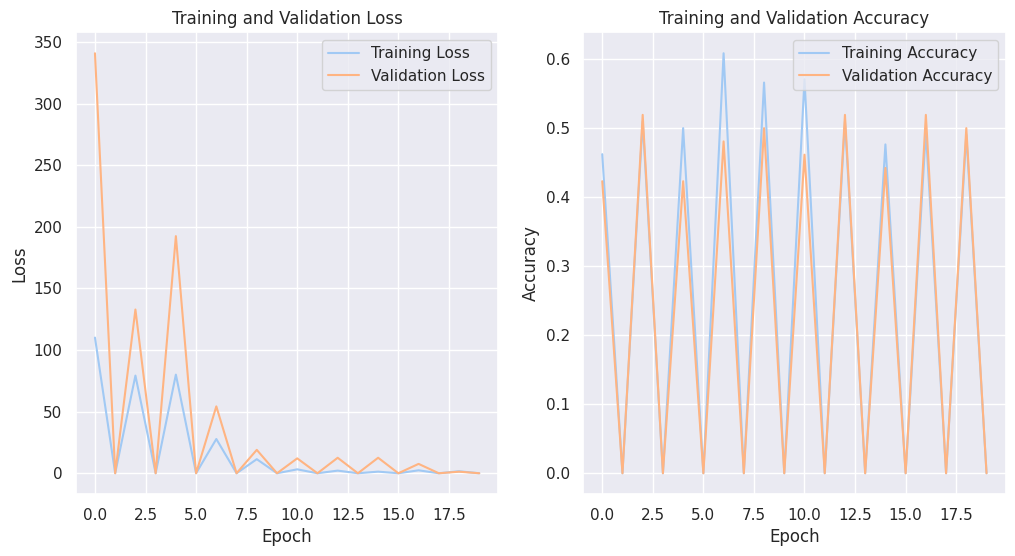

In [127]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and index 1
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and index 2
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [129]:
pred = vgg_model.predict(val_set)
pred = np.argmax(pred,axis=1)
pred[:5]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step


array([0, 1, 0, 0, 0])

In [130]:
labels = (val_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [131]:
pred = [labels[k] for k in pred]
pred[:5]

['Angry', 'Happy', 'Angry', 'Angry', 'Angry']

In [134]:
from sklearn.metrics import accuracy_score,classification_report

y_val = list(val_labels)

print('Accuracy Score: {:.3f}'.format(accuracy_score(y_val,pred)))
print(classification_report(y_val,pred))

ValueError: Found input variables with inconsistent numbers of samples: [106, 52]